In [1]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict
if "../" not in sys.path:
  sys.path.append("../") 
from lib.envs.blackjack import BlackjackEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [2]:
env = BlackjackEnv()

In [3]:
def create_random_policy(nA):
    """
    Creates a random policy function.
    
    Args:
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities
    """
    A = np.ones(nA, dtype=float) / nA
    def policy_fn(observation):
        return A
    return policy_fn

In [4]:
def create_greedy_policy(Q):
    """
    Creates a greedy policy based on Q values.
    
    Args:
        Q: A dictionary that maps from state -> action values
        
    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities.
    """
    def policy_fn(observation):
        action_dist = np.zeros(len(Q[observation]), dtype=float)
        best = np.argmax(Q[observation])
        action_dist[best] = 1.0

        return action_dist

    return policy_fn

In [ ]:
def mc_control_importance_sampling(env, num_episodes, behavior_policy, discount_factor=1.0):
    """
    Monte Carlo Control Off-Policy Control using Weighted Importance Sampling.
    Finds an optimal greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        behavior_policy: The behavior to follow while generating episodes.
            A function that given an observation returns a vector of probabilities for each action.
        discount_factor: Gamma discount factor.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities. This is the optimal greedy policy.
    """
    
    # The final action-value function.
    # A dictionary that maps state -> action values
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    C = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Our greedily policy we want to learn
    target_policy = create_greedy_policy(Q)
    
    for _ in range(num_episodes):
        state = env.reset()
        ep = []
        while True:
            dist = behavior_policy(state)
            action = np.random.choice(np.arange(len(dist)), p=dist)
            next_state, reward, done, _ = env.step(action)
            ep.append((state, action, reward))

            if done:
                break
            state = next_state
        
        G_t = 0
        W = 1
        for state, action, reward in reversed(ep):
            C[state][action] += W
            G_t = reward + G_t*discount_factor
            Q[state][action] += W / C[state][action] * (G_t - Q[state][action])

            # Assuming greedy policy ~ 1/b as target policy is deterministic
            W *= target_policy(state)[action] / behavior_policy(state)[action]
            # If target policy does not take behavior policy's action
            # P_target = 0 -> W = 0
            if W == 0.0: break
        
    return Q, target_policy

In [57]:
random_policy = create_random_policy(env.action_space.n)
Q, policy = mc_control_importance_sampling(env, num_episodes=500000, behavior_policy=random_policy)

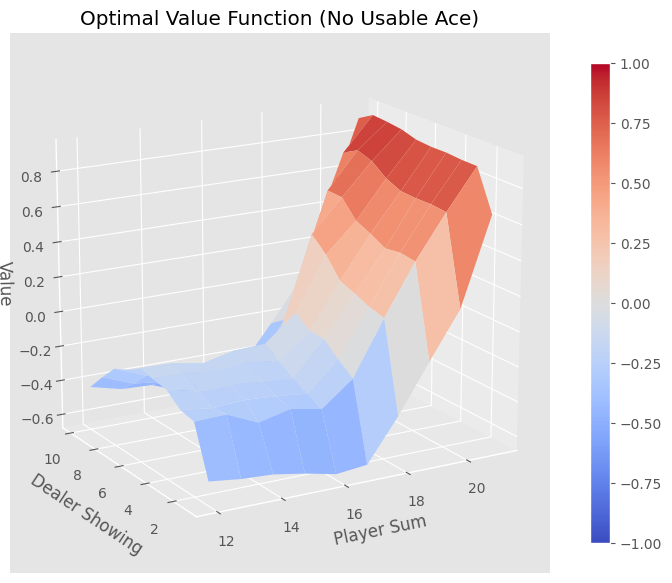

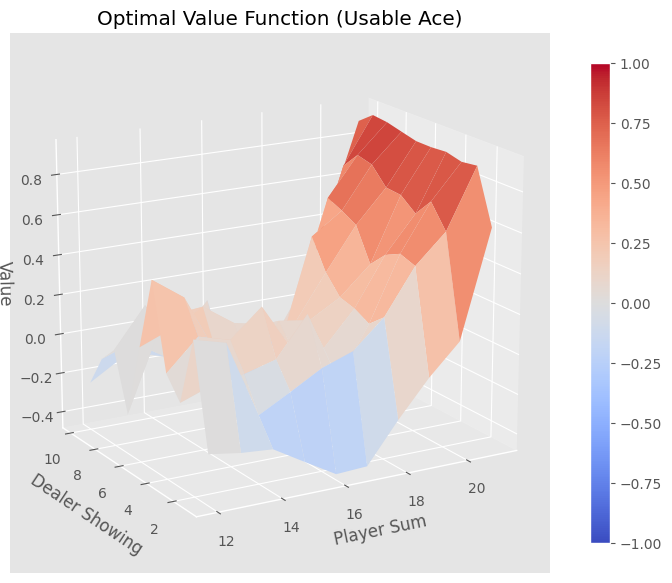

In [71]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
import importlib
importlib.reload(plotting)

V = defaultdict(float)
for state, action_values in Q.items():
    action_value = np.max(action_values)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")